In [257]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.8.0
1.5.3
1.24.2


# Step 1. 데이터 불러오기
   

In [258]:
data_dir = os.getenv("HOME") + '/aiffel/DATA'

In [259]:
data_test_path = data_dir+"/data_test_spm_4000_0317.pkl"
full_data_test = pd.read_pickle(data_test_path, 'gzip')
full_data_test['weight'] = full_data_test['tok_cat'].apply(lambda x : 14 - x)
full_data_test = full_data_test.loc[full_data_test['tok_cat'] < 6].sample(n=250, weights = 'weight' ,random_state=6) # validation 시간이 너무 오래 걸림
test_idx = full_data_test.index

In [358]:
# # train data load
data_dir = os.getenv('HOME')+'/aiffel/DATA' # 파일 경로 지정
data_train_path = data_dir+"/data_train_custom_msp_8000_0322.pkl"
data_test_path = data_dir+"/data_train_custom_msp_8000_0322.pkl"
full_data = pd.read_pickle(data_train_path, 'gzip')
full_data_test = pd.read_pickle(data_test_path, 'gzip')
full_data_test = full_data_test.iloc[test_idx].copy()

In [359]:
full_data['weights'] = full_data['reg'].map({'kw':0.06, 'jj':0.122,'jd':0.180,'gs':0.29,'cc':0.37})
full_data = full_data.sample(720000,weights='weights',random_state=2)

In [360]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720000 entries, 692484 to 186503
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   reg       720000 non-null  object 
 1   topic     720000 non-null  object 
 2   eng       720000 non-null  object 
 3   dial      720000 non-null  object 
 4   tok_len   720000 non-null  int64  
 5   tok_cat   720000 non-null  int64  
 6   toks_en   720000 non-null  object 
 7   toks_dec  720000 non-null  object 
 8   weights   720000 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 54.9+ MB


In [363]:
full_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 1362 to 893
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       250 non-null    object
 1   topic     250 non-null    object
 2   eng       250 non-null    object
 3   dial      250 non-null    object
 4   tok_len   250 non-null    int64 
 5   tok_cat   250 non-null    int64 
 6   toks_en   250 non-null    object
 7   toks_dec  250 non-null    object
dtypes: int64(2), object(6)
memory usage: 17.6+ KB


In [364]:
regs = full_data.reg.unique()

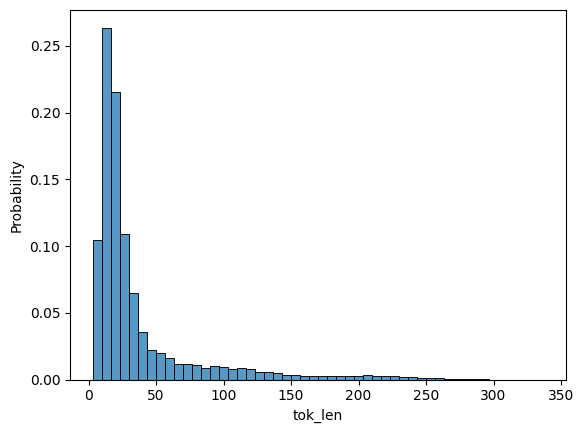

In [365]:
import seaborn as sns
full_data['tok_len'] = full_data['toks_dec'].apply(lambda x : len(x))
sns.histplot(x='tok_len',data = full_data, bins= 50,stat='probability' )
plt.show()

In [366]:
full_data.groupby(full_data['reg'])['tok_len'].mean()

reg
cc    44.112788
gs    42.976029
jd    39.011275
jj    28.818398
kw    30.652143
Name: tok_len, dtype: float64

In [367]:
full_data['tok_cat'] = pd.qcut(full_data['tok_len'], [0,0.7,0.8,0.85,0.9,0.92,0.94,0.96,0.98,0.985,0.986,0.994,0.999,1],labels =[1,2,3,4,5,6,7,8,9,10,11,12,13])

In [368]:
full_data.loc[full_data['tok_cat']==7,'tok_len'].agg([min,max])

min    126
max    152
Name: tok_len, dtype: int64

In [369]:
data_path = os.getenv('HOME') + '/aiffel/saturi/notebook/Preprocessing/'
SRC_VOCAB_SIZE = 8009
TGT_VOCAB_SIZE = 8009

enc_tokenizer = spm.SentencePieceProcessor()
enc_tokenizer.Load(data_path+'spm_enc_8009.model')

dec_tokenizer = spm.SentencePieceProcessor()
dec_tokenizer.Load(data_path+'spm_dec_custom_msp8009.model')

dec_tokenizer.set_encode_extra_options("bos:eos")

True

# Step 2. 모델불러오기

In [270]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [386]:
#wandb 설정
run  = wandb.init(project = 'model_exp_custom_msp_8009_0322v_test_max_b3',
                 entity = 'saturi',
                 config = {
                     'model_name':'Vanilla_Transformer',
                     'n_layers':4,
                     'd_model':512,
                     'n_heads':8,
                     'd_ff':2048,
                     'src_vocab_size':SRC_VOCAB_SIZE,
                     'tgt_vocab_size':TGT_VOCAB_SIZE,
                     'pos_len': 512,
                     'dropout':0.2,
                     'shared':True,
                     'warmups' : 4000,
                     'epochs':1,
                     'optimizer' :'ADAM',
                     'loss' : 'SparseCategoricalCrossentropy',
                     'metric' : 'bleu'
                 })
config = wandb.config

train_loss,█▄▄▃▄▄▄▃▂▂▁▁▂
valid_loss,▄▂█▄██▃▁▇▄▃▇█
train_loss,3.26128
valid_loss,4.43982


In [387]:
import sys
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/MODEL/') # vanilla transformer 파일경로에서 불러오기 위해 설정
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/PRE/')
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/POST/')

In [388]:
from vanilla_transformer import Transformer, generate_masks

transformer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=config.src_vocab_size,
    tgt_vocab_size=config.tgt_vocab_size,
    pos_len=config.pos_len,
    dropout=config.dropout,
    shared=config.shared
)

##  Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언

In [389]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=config.warmups):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** np.array(-0.5)
        arg2 = step * np.array(self.warmup_steps ** -1.5)
        
        return np.array(self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [390]:
learningrate = LearningRateScheduler(512)

In [391]:
optimizer = tf.keras.optimizers.Adam(learningrate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의


In [392]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의


In [393]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns, predictions

In [394]:
# Validating the model
@tf.function
def model_validate(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    v_loss = loss_function(gold, predictions[:, :-1])
    
    return v_loss, predictions

In [396]:
# 학습 매니저 설정
from evaluation import evaluate, compute_metric

def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        total_loss = 0
        total_loss_val = 0
        bleu_train = 0
        bleu_valid = 0
        

        idx_list = list(range(0, enc_train.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)
        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns, preds = train_step(enc_train[idx:idx+batch_size],
                                                                         dec_train[idx:idx+batch_size],
                                                                         transformer,
                                                                         optimizer)

            total_loss += batch_loss
            
            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
            
        #validation
        for test_idx in range(0,enc_test.shape[0], batch_size) :
            val_loss, val_preds = model_validate(enc_test[test_idx : test_idx + batch_size],
                                      dec_test[test_idx : test_idx + batch_size],
                                      transformer)
            total_loss_val += val_loss

        wandb.log({
                   "train_loss": total_loss.numpy() / (len(t) + 1),
                   "valid_loss" : total_loss_val.numpy() / (enc_test.shape[0]//batch_size),
                   })

        save_path = manager.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
        
directory = os.getenv('HOME') + '/aiffel/MODEL/'
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, directory +'tf_custom_msp8000_ckpt_0322v_max_b3',max_to_keep=3)

## 학습

In [ ]:
#bucketing and training

batch_size = 32
buckets = iter(full_data['tok_cat'].unique().tolist())

for bucket in buckets :

    src_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_en'].values
    tgt_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_dec'].values
    src_valid_corpus = full_data_test['toks_en'].values
    tgt_valid_corpus = full_data_test['toks_dec'].values
    max_len = full_data.loc[full_data['tok_cat']==bucket,'tok_len'].max()
    
    if max_len > 380 :
        batch_size = 8
        
    if max_len > 512 : 
        max_len = 512
        
    enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post', maxlen=max_len)
    dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post', maxlen=max_len)
    enc_test = tf.keras.preprocessing.sequence.pad_sequences(src_valid_corpus, padding='post', maxlen=max_len)
    dec_test = tf.keras.preprocessing.sequence.pad_sequences(tgt_valid_corpus, padding='post', maxlen=max_len)

    print(enc_train.shape)
    print(dec_train.shape)
    print(enc_test.shape)
    print(dec_test.shape)
    
    
    #Train
    train_and_checkpoint(transformer, manager, config.epochs)

(507935, 30)
(507935, 30)
(250, 30)
(250, 30)
Restored from /home/seuyon0101/aiffel/MODEL/tf_custom_msp8000_ckpt_0322v_max_b3/ckpt-13


Epoch  1:  60%|████████▉      | 9446/15873 [05:18<03:41, 28.96it/s, Loss 3.2137]

# Step 3. 평가

In [398]:
from evaluation import translate
from time import perf_counter

In [399]:
examples = ["<jj> what are you doing ?",'<cc> what are you doing ?','<gs> what are you doing ?','<jd> what are you doing ?','<kw> what are you doing ?']

In [400]:
examples = ["<jj> i like this song . ",'<cc> i like this song . ','<gs> i like this song . ','<jd> i like this song . ','<kw> i like this song . ']

In [401]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> i like this song . 
Predicted translation: 요 노래를 요 노래를 잘도 좋아하
Input: <cc> i like this song . 
Predicted translation: 유 노래를 쫌 좋아하는 편이에
Input: <gs> i like this song . 
Predicted translation: 예 노래가 쫌 예 노래를 드나
Input: <jd> i like this song . 
Predicted translation: 요잉 노래를 좀 좋아하는 거이 같
Input: <kw> i like this song . 
Predicted translation: 요 노래는 요 노래를 좋아하라
4.303536022001936


In [285]:
full_data_test.sort_values(by='tok_cat', inplace=True)

In [286]:
test_text = full_data_test.eng.values
test_tgt = full_data_test.dial.values

In [312]:
from datasets import load_metric
bleu = load_metric("sacrebleu")
test_translate = []
bleu_valid_score = []
for i in tqdm(range(len(test_text))) :
    trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
    test_translate.append(trans)
    label = dec_tokenizer.decode(test_tgt[i])
    result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
    bleu_valid_score.append(result)

100%|█████████████████████████████████████████| 250/250 [10:28<00:00,  2.51s/it]


In [313]:
sum(bleu_valid_score)/len(test_text)

10.21284738627495

In [290]:
wandb.log({"bleu": sum(bleu_valid_score)/len(test_text)})

In [291]:
full_data_test['bleu'] = np.array(bleu_valid_score)
full_data_test['pred'] = test_translate

In [292]:
full_data_test.loc[:,['tok_cat','topic','reg','dial','pred','bleu']].sort_values('bleu')

,tok_cat,topic,reg,dial,pred,bleu
1362,1,자동차/오토바이,jd,지짜 다르드라.,하도 달르고 긍게,0.000000
1138,1,스타일,jd,고거 어뜨케 나가 머리에서 나왔겄어?,내잉 머릿속에 으째가 이르케 빠져나가,0.000000
1182,1,드라마,jd,평민이든 서민이든 근께,일반인이든 일반인들이든 일반인들을 보내든지,0.000000
585,1,방송/연예,jd,착하면 되야 잉 착한디 그~ 생긴 꺼는 약깐 귀엽게 생겨가꼬,그려 그려 근디 좀 기여운 보이기도 허고 그른 거이 같기도,0.000000
673,1,쇼핑,jd,나이키랑 쩌기 캘리포니아에서 스투시라는 인제 스포츠 브랜드가 조석,쩌쪽에 있디야 칼로리 브랜드를 제외하고 스시라는 그른 스포츠가,0.000000
...,...,...,...,...,...,...
1103,1,건강,jd,이십대만 하것능가?,걍 이십대?,48.549177
546,1,반려동물,jd,애완동물은 재산이여 아니여?,애완동물은 재산이여?,54.444606
436,1,방송/연예,jj,근디,근디 나는이,70.710678
1446,1,꿈(목표),jj,우에,우에,100.000000


In [293]:
data_dir = os.getenv('HOME')+'/aiffel/DATA' # 파일 경로 지정
full_data_test.to_csv(data_dir + '/test_results_custom_msp8000_max.csv')

In [294]:
wandb.finish()

bleu,▁
bleu,12.55479
